In [1]:
%matplotlib inline

In [2]:
import numpy as np
import openturns as ot
import matplotlib.pyplot as plt
import ctbenchmark as ctb

# Gaussian peak problem description

In [3]:
problem = ctb.CentralTendencyIrregularProblem()
function = problem.getFunction()
distribution = problem.getDistribution()
problem_name = problem.getName()

In [4]:
problem.getMean()

0.802416025496437

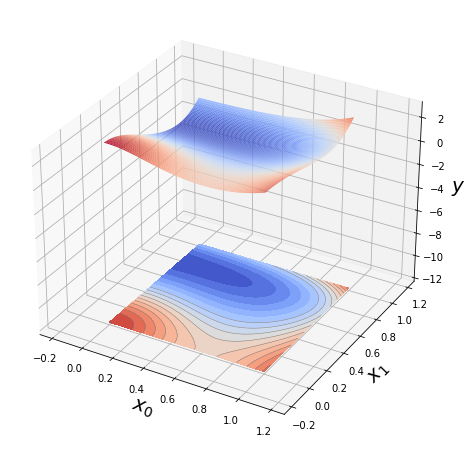

In [5]:
d = ctb.DrawFunctions()
fig = d.draw_full_3D(function, 'Gaussian peak function', -12)
fig

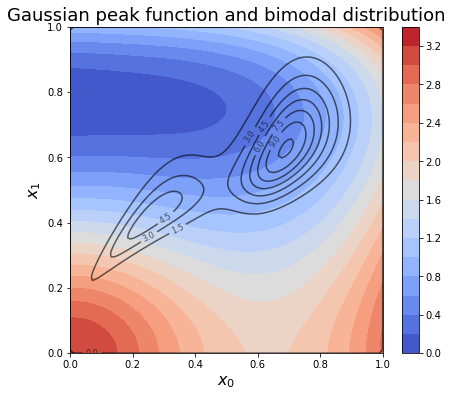

In [6]:
fig = d.draw_2D_controur('Gaussian peak function and bimodal distribution', function, distribution)
fig;

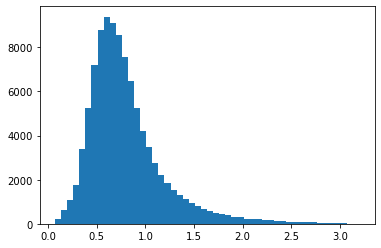

In [7]:
## Output pdf illustration
output_rv = problem.getRandomVector()
output_sample = output_rv.getSample(100000)
plt.hist(np.array(output_sample).flatten(), 50);

## Kernel based sampling methods

In [8]:
n = 30
doe_generator = ctb.CentralTendencyBenchmark()
candidate_points = doe_generator.generate_sample('sobol', 2**13, distribution, None)

In [9]:
kh_sample = doe_generator.generate_sample('kernel herding', n, None, candidate_points)
sp_sample = doe_generator.generate_sample('support points', n, None, candidate_points)

In [10]:
kh_weights = doe_generator.compute_bayesian_quadrature_weights(kh_sample, candidate_points)
sp_weights = doe_generator.compute_bayesian_quadrature_weights(sp_sample, candidate_points)

In [11]:
kh_weights

array([-0.05548132,  0.01849955,  0.03610638,  0.02285146,  0.02381002,
        0.02995136,  0.02803651,  0.05983896,  0.02052974,  0.10295267,
        0.04398079,  0.05735299,  0.03013823,  0.0422895 ,  0.04820655,
        0.03179337,  0.02144182,  0.08862632,  0.0484769 ,  0.03880327,
        0.03752298,  0.05812517,  0.08171535,  0.01509369,  0.00245562,
        0.02337618, -0.03836642,  0.01559692,  0.03425235,  0.0272017 ])

In [12]:
np.sum(kh_weights)

0.9951786113899848

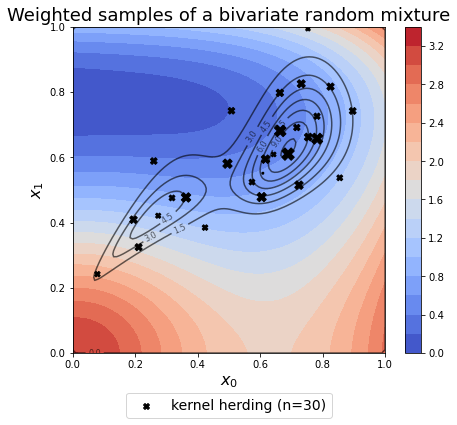

In [13]:
fig = d.draw_2D_controur('Weighted samples of a bivariate random mixture', function, distribution)
#plt.scatter(mc_design[:, 0], mc_design[:, 1], label='Monte Carlo (n={})'.format(size), marker='o', alpha=0.5)
plt.scatter(kh_sample[:, 0], kh_sample[:, 1], label='kernel herding (n={})'.format(n), marker='X', color='k', s=kh_weights * 1500)
#plt.scatter(sp_sample[:, 0], sp_sample[:, 1], label='Support points (n={})'.format(n), marker='D', color='lime', s=sp_weights*1000)
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', fontsize=14)
fig.savefig('figures/irregular_sample.pdf', bbox_inches='tight');

# Benchmark

In [14]:
x_bench_sizes = list(range(6, 20, 2)) + list(range(20, 50, 5)) + list(range(50, 160, 10))
my_methods = ['kernel herding', 'support points', 'sobol']
bench = ctb.CentralTendencyBenchmark(my_methods, x_bench_sizes)

In [15]:
df_benchmark = bench.run_benchmark([problem], candidate_points)
df_benchmark = df_benchmark.reset_index()
df_benchmark.to_csv('results/ct_benchmark_{}.csv'.format(problem_name), index=False)
df_benchmark

START: problem=CT_irregular_problem | method=kernel herding
START: problem=CT_irregular_problem | method=support points
START: problem=CT_irregular_problem | method=sobol
DONE: problem=CT_irregular_problem | method=sobol
DONE: problem=CT_irregular_problem | method=support points
DONE: problem=CT_irregular_problem | method=kernel herding


,Problem,Method,Size,mu,m,m*,MMD,weights sum
0,CT_irregular_problem,kernel herding,6,0.802416,0.777814,0.72856,NaN,0.947054
1,CT_irregular_problem,kernel herding,8,0.802416,0.755013,0.705612,NaN,0.941035
2,CT_irregular_problem,kernel herding,10,0.802416,0.897789,0.778262,NaN,0.96918
3,CT_irregular_problem,kernel herding,12,0.802416,0.873837,0.784547,NaN,0.974565
4,CT_irregular_problem,kernel herding,14,0.802416,0.826611,0.778827,NaN,0.983469
...,...,...,...,...,...,...,...,...
67,CT_irregular_problem,support points,110,0.802416,0.792,0.795084,NaN,0.996586
68,CT_irregular_problem,support points,120,0.802416,0.791999,0.795368,NaN,0.996796
69,CT_irregular_problem,support points,130,0.802416,0.798471,0.796077,NaN,0.997163
70,CT_irregular_problem,support points,140,0.802416,0.797343,0.796003,NaN,0.997167


In [16]:
df_benchmark = df_benchmark.reset_index()

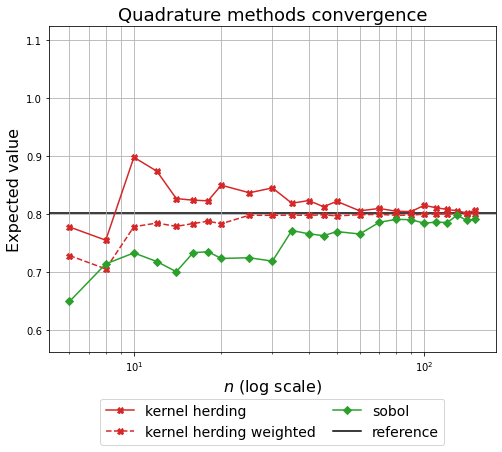

In [17]:
function_label = problem.getName()
my_methods = ['kernel herding', 'sobol']

markers = "XD^Xo^v."
fig = plt.figure(figsize=(8, 6))
plt.title("Quadrature methods convergence", fontsize=18)
colors = ['C3', 'C2']
for idx, method in enumerate(my_methods):
    df = df_benchmark[(df_benchmark["Problem"]==function_label) &
                        (df_benchmark["Method"]==method)]
    mu_ref = df['mu'].tolist()[0]
    idx = my_methods.index(method)
    plt.plot(df["Size"], df["m"], marker=markers[idx], label=method, color=colors[idx], zorder=2)
    if method=='kernel herding':
        plt.plot(df["Size"], df["m*"], marker=markers[idx], linestyle='dashed', label=method + ' weighted', color=colors[idx])
#plt.scatter(df["Size"].max() + 1000, df['mu'].tolist()[0], marker='D', color='k')
plt.axhline(y=mu_ref, color='k', linewidth=1.5, zorder=0, label='reference')

plt.grid(which='both')
plt.xlabel('$n$ (log scale)', fontsize=16)
plt.ylabel('Expected value', fontsize=16)
plt.xscale('log')
plt.ylim([0.7 * mu_ref, 1.4 * mu_ref])
legend = plt.legend(bbox_to_anchor=(0.5, -0.12), loc='upper center', ncol=2, columnspacing=1.2, fontsize=14)
fig.savefig('figures/irregular_convergence.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')